Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing all the important libraries

In [1]:
import pandas as pd
import tensorflow as tf
import PIL
from glob import glob
import pathlib
import os 
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

Importing Skin Cancer Data <br>

In [2]:
# After mounting Google drive , unzipping the assignment file

!unzip "/content/drive/MyDrive/CNN_assignment.zip"

Archive:  /content/drive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating:

# Data Reading/Data Understanding

In [3]:
# Defining the path for train and test images

train_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
# Checking the number of files in Train & Test folders

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset Creation

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Creating Training dataset

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=42, validation_split=0.2, subset='training',
    interpolation='bilinear')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Creating Validation dataset

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', validation_split=0.2,
    subset="validation", batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=42, interpolation='bilinear')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.

class_names = train_data.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation

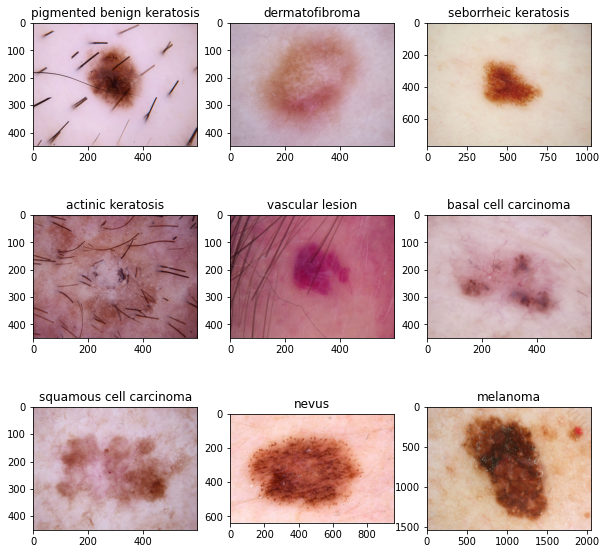

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Function to display image
def show_img(file):
  img = PIL.Image.open(file)
  plt.subplot(3,3,cnt+1)
  plt.title(str(dirpath).split('/')[-1])
  plt.axis()
  plt.imshow(img)

# Plotting image from each class
cnt=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        file_path = str(dirpath)+"/"+str(filename)
        show_img(file_path)
        cnt=cnt+1

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training M1

In [11]:
shape=(img_width, img_height, 3)

#Initialising the CNN
model = tf.keras.models.Sequential()

#Convolutional Layer
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.ReLU(), input_shape=(shape)))

# Resizing
model.add(tf.keras.layers.Rescaling(1.0 / 255))

#Pooling Layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.ReLU()))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

#Flattening
model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
model.add(tf.keras.layers.Dense(units = 9, activation = 'softmax'))

**Compile the model**

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 512)     14336     
                                                                 
 rescaling (Rescaling)       (None, 178, 178, 512)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 473344)            0

**Train the model**

In [14]:
epochs = 20
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
) 

Epoch 1/20
56/56 [==============================] - 41s 458ms/step - loss: 2.6930 - accuracy: 0.1987 - val_loss: 2.0564 - val_accuracy: 0.1588
Epoch 2/20
56/56 [==============================] - 26s 436ms/step - loss: 1.9938 - accuracy: 0.2383 - val_loss: 1.9448 - val_accuracy: 0.2864
Epoch 3/20
56/56 [==============================] - 26s 434ms/step - loss: 1.9264 - accuracy: 0.2812 - val_loss: 1.8430 - val_accuracy: 0.3199
Epoch 4/20
56/56 [==============================] - 26s 436ms/step - loss: 1.7304 - accuracy: 0.3583 - val_loss: 1.5723 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 26s 438ms/step - loss: 1.6129 - accuracy: 0.4364 - val_loss: 1.7767 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 26s 439ms/step - loss: 1.5813 - accuracy: 0.4470 - val_loss: 1.5232 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 26s 443ms/step - loss: 1.4260 - accuracy: 0.4939 - val_loss: 1.4915 - val_accuracy: 0.4989

Visualizing training results

In [15]:
def model_validation(model_history):
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

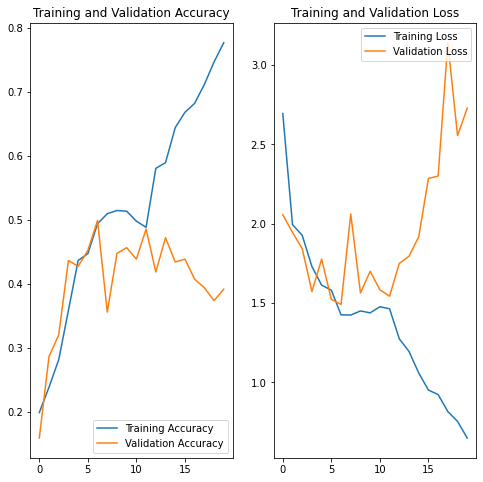

In [16]:
model_validation(history)

Findings

From above results it's clear that the model is underfitting. <br>
Training & Validation accuracy are both below 30%

# Selecting appropriate data augmentation strategy to resolve underfitting/overfitting 

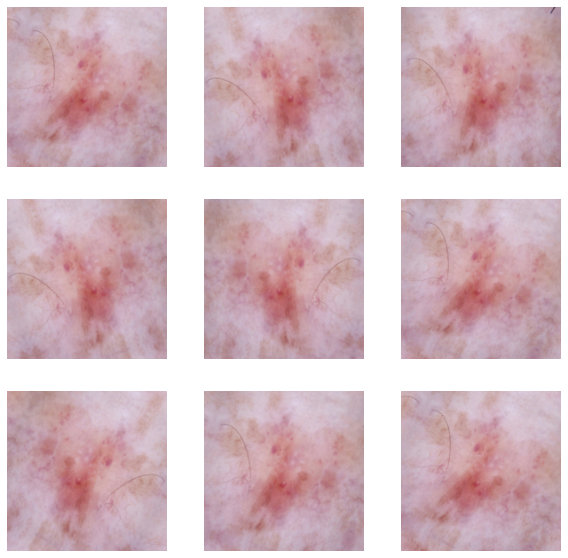

In [22]:
# Augmentation of single instance

data_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Model Building & training on the augmented data M2

In [18]:
shape=(img_width, img_height, 3)

#Initialising the CNN
aug_model = tf.keras.models.Sequential()

#Convolutional Layer
aug_model.add(tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.ReLU(), input_shape=(shape)))

# Augmentation Layer
aug_model.add(data_augmentation)

# Resizing
aug_model.add(tf.keras.layers.Rescaling(1.0 / 255))

#Pooling Layer
aug_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
aug_model.add(tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.ReLU()))
aug_model.add(tf.keras.layers.MaxPooling2D((2, 2)))

#Flattening
aug_model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
aug_model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
aug_model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
aug_model.add(tf.keras.layers.Dense(units = 9, activation = 'softmax'))

In [19]:
aug_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


aug_history = aug_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 52s 829ms/step - loss: 2.4654 - accuracy: 0.1908 - val_loss: 2.0284 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 47s 822ms/step - loss: 1.9914 - accuracy: 0.2489 - val_loss: 1.9006 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 47s 826ms/step - loss: 1.8806 - accuracy: 0.2907 - val_loss: 1.7639 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 47s 820ms/step - loss: 1.7987 - accuracy: 0.3398 - val_loss: 1.6588 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 47s 826ms/step - loss: 1.6639 - accuracy: 0.4023 - val_loss: 1.5676 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 47s 820ms/step - loss: 1.6669 - accuracy: 0.3956 - val_loss: 1.5710 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 47s 823ms/step - loss: 1.6525 - accuracy: 0.4018 - val_loss: 1.6030 - val_accuracy: 0.4362

Visualizing the results

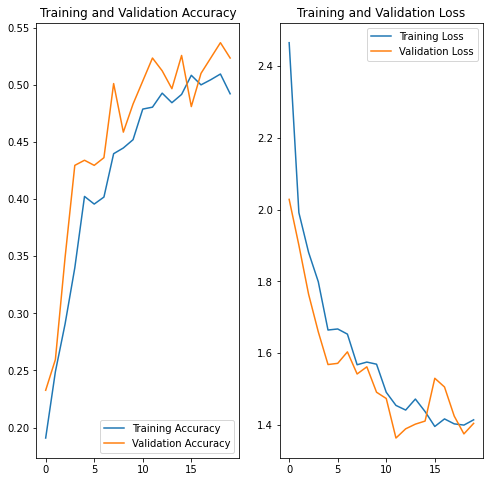

In [20]:
model_validation(aug_history) 

Findings

*   After adding an Augmentation layer we can see the training accuracy has decreased but validation accuracy has increased.<br>
*   Here model is not overfitted but is generalised on both training & vaidation sets but still suffers with low training accuracy.



# Class distribution

In [21]:
for i in class_names:
    directory =train_path+'/'+i
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


1. Which class has the least number of samples?

From above data we can see 'seborrheic keratosis' has the lowest number of samples.

2. Which classes dominate the data in terms of the proportionate number of samples?

From above data we can see 'pigmented benign keratosis' has the highest number of samples.

# Handling class imbalances

In [11]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(train_path +'/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F63E7590790>: 100%|██████████| 500/500 [00:19<00:00, 25.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F637009FC50>: 100%|██████████| 500/500 [00:19<00:00, 25.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F636ECA7A10>: 100%|██████████| 500/500 [00:19<00:00, 25.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F636D745B10>: 100%|██████████| 500/500 [01:39<00:00,  5.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6364030590>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F637188C090>: 100%|██████████| 500/500 [00:17<00:00, 29.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F63644E2850>: 100%|██████████| 500/500 [00:41<00:00, 12.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63644DA990>: 100%|██████████| 500/500 [00:18<00:00, 27.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F63F9BA0490>: 100%|██████████| 500/500 [00:16<00:00, 29.69 Samples/s]


In [13]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Distribution of augmented data after adding new images to the original training data.

In [14]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027584.jpg_ca97e0c5-0ad7-4a63-9e2b-161cbd96970b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027026.jpg_1cb76f06-fac5-43db-8769-64ef8bbb72c3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025575.jpg_7186acc0-817b-41b6-9a8f-b47529ddadce.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028376.jpg_7bf309d6-7906-4c5c-8870-0018dceb4c84.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024623.jp

In [15]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [16]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new)) 

In [17]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = dataframe_dict_new.append(df2)

In [18]:
for i in class_names:
    directory =train_path+'/'+i
    directory_out =directory+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


Train the model on the data created using Augmentor

In [19]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=42, validation_split=0.2, subset='training',
    interpolation='bilinear')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=42, validation_split=0.2, subset='validation',
    interpolation='bilinear')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data M3

In [27]:
shape=(img_width, img_height, 3)

#Initialising the CNN
opt_model = tf.keras.models.Sequential()

#Convolutional Layer
opt_model.add(tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.ReLU(), input_shape=(shape)))

# Resizing
opt_model.add(tf.keras.layers.Rescaling(1.0 / 255))

#Pooling Layer
opt_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
opt_model.add(tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.ReLU()))
opt_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
opt_model.add(tf.keras.layers.Dropout(0.5))
opt_model.add(tf.keras.layers.BatchNormalization())

#Flattening
opt_model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
opt_model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
opt_model.add(tf.keras.layers.Dropout(0.2))
opt_model.add(tf.keras.layers.BatchNormalization())
opt_model.add(tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.ReLU()))
opt_model.add(tf.keras.layers.Dense(units = 9, activation = 'softmax'))

In [28]:
opt_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
opt_history = opt_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 73s 419ms/step - loss: 1.7055 - accuracy: 0.3654 - val_loss: 13.2985 - val_accuracy: 0.1002
Epoch 2/30
169/169 [==============================] - 73s 424ms/step - loss: 1.4316 - accuracy: 0.4611 - val_loss: 2.9727 - val_accuracy: 0.2465
Epoch 3/30
169/169 [==============================] - 71s 415ms/step - loss: 1.3263 - accuracy: 0.4991 - val_loss: 4.5623 - val_accuracy: 0.2101
Epoch 4/30
169/169 [==============================] - 71s 415ms/step - loss: 1.3287 - accuracy: 0.4892 - val_loss: 2.5771 - val_accuracy: 0.2494
Epoch 5/30
169/169 [==============================] - 72s 417ms/step - loss: 1.2659 - accuracy: 0.5202 - val_loss: 2.7908 - val_accuracy: 0.2287
Epoch 6/30
169/169 [==============================] - 71s 416ms/step - loss: 1.1574 - accuracy: 0.5640 - val_loss: 1.6633 - val_accuracy: 0.3964
Epoch 7/30
169/169 [==============================] - 71s 415ms/step - loss: 1.0592 - accuracy: 0.6050 - val_loss: 1.1338 - val_a

Findings

*   From above Results we can see that the training accuracy has improved a lot and reached more than 80%. <br>
*   But the validation accuracy is not consistent and is fluctuating. <br>
*   By adding some more layers or tuning existing layers & training the model for more epochs we can get a Good Generalized model that will work well on unkown data.



